In [1]:
import cvxpy as cp
import numpy as np
import pandas as pd
import seaborn as sns

from matplotlib import pyplot as plt
from os import path
from linear_opt.lin_resp import LinearRespirationModel

from SALib import ProblemSpec

In [3]:
model_dir = '../models/linear/autotrophy/'
m_fname = path.join(model_dir, 'glucose_auto_molecular_props.csv')
S_fname = path.join(model_dir, 'glucose_auto_stoich_matrix.csv')
lam = LinearRespirationModel.FromFiles(m_fname, S_fname)

In [4]:
# Do a quick run of the model to make sure it is feasible
p = lam.max_anabolic_rate_problem()
res = p.solve(verbose=True)
p.value

                                     CVXPY                                     
                                     v1.2.1                                    
(CVXPY) Jul 12 10:40:29 AM: Your problem has 4 variables, 3 constraints, and 9 parameters.
(CVXPY) Jul 12 10:40:29 AM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 12 10:40:29 AM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Jul 12 10:40:29 AM: Compiling problem (target solver=ECOS).
(CVXPY) Jul 12 10:40:29 AM: Reduction chain: EvalParams -> FlipObjective -> Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> ECOS
(CVXPY) Jul 12 10:40:29 AM: Applying reduction EvalParams
(CVXPY) Jul 12 10:40:29 AM: Applying r

/opt/miniconda3/lib/python3.8/site-packages/cvxpy/reductions/solvers/solving_chain.py:178: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Discplined Parametrized Programming, at
	https://www.cvxpy.org/tutorial/advanced/index.html#disciplined-parametrized-programming
  warnings.warn(dpp_error_msg)


7.45522388060241e-05

In [10]:
p = lam.max_anabolic_rate_problem(phi_o=0.0, fix_lambda=True)
phis = []
lambdas = np.arange(0.01, 1.001, 0.01)

for lam_val in lambdas:
    p.param_dict['lambda_hr'].value = lam_val
    res = p.solve()
    if p.status in ("infeasible", "unbounded"):
        phis.append(np.zeros(lam.S_df.index.size + 1))
        continue
    phis.append(p.var_dict['phis'].value.tolist() + [p.param_dict['phi_o'].value])    

colnames = lam.S_df.index.values.tolist() + ['other']
print(colnames)
print(phis)
phi_df = pd.DataFrame(phis, columns=colnames)
phi_df['lambda_hr'] = lambdas
phi_df.set_index('lambda_hr', inplace=True)
phi_df.head()

/opt/miniconda3/lib/python3.8/site-packages/cvxpy/reductions/solvers/solving_chain.py:178: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Discplined Parametrized Programming, at
	https://www.cvxpy.org/tutorial/advanced/index.html#disciplined-parametrized-programming
  warnings.warn(dpp_error_msg)


['oxidation', 'reduction', 'anabolism', 'ATP_homeostasis', 'other']
[array([0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0.]), arr

,oxidation,reduction,anabolism,ATP_homeostasis,other
lambda_hr,,,,,
0.01,0.0,0.0,0.0,0.0,0.0
0.02,0.0,0.0,0.0,0.0,0.0
0.03,0.0,0.0,0.0,0.0,0.0
0.04,0.0,0.0,0.0,0.0,0.0
0.05,0.0,0.0,0.0,0.0,0.0


Text(0, 0.5, '$\\phi$')

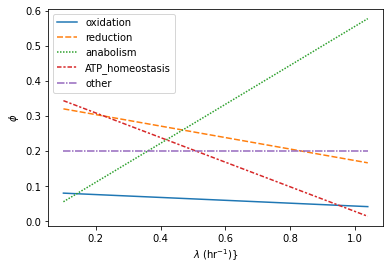

In [5]:
mask = (phi_df != 0).all(axis=1)
sns.lineplot(data=phi_df[mask])
plt.xlabel(r'$\lambda$ (hr$^{-1}$)}')
plt.ylabel(r'$\phi$')   

In [6]:
# Use the SAlib tools to generate parameters for a sensitivity analysis
ps = ProblemSpec({
        "names": ["phi_o", "S6", "m_resp", "resp_ATP_per_e", "m_ATP_homeostasis"],
        "groups": None,
        "bounds": [[0.3, 0.5], [-0.5, 0.5], [10, 10000], [0.2, 2], [10, 10000],],
        "outputs": ["lambda_max"],
    })
ps.sample_sobol(64)

# Store the results in a dictionary for making a dataframe
res_dict = dict(ZCB=[], S6=[], phi_O=[], lambda_max=[], m_resp=[],
                resp_ATP_per_e=[], m_ATP_homeostasis=[])
for p in list(lam.processes) + ['other']:
    res_dict['{0}_phi'.format(p)] = []
    res_dict['{0}_flux'.format(p)] = []

for phi_o, s6, m_resp, atp_per_e, m_homeo in ps.samples:
    lam.set_S6(s6)
    lam.set_process_mass('reduction', m_resp)
    lam.set_process_mass('ATP_homeostasis', m_homeo)
    lam.set_ATP_yield('reduction', atp_per_e)
    max_lam, opt_prob = lam.maximize_lambda(phi_o=phi_o)

    res_dict['ZCB'].append(lam.ZCB)
    res_dict['S6'].append(s6)
    res_dict['phi_O'].append(phi_o)
    res_dict['m_resp'].append(m_resp)
    res_dict['resp_ATP_per_e'].append(atp_per_e)
    res_dict['m_ATP_homeostasis'].append(m_homeo)

    if max_lam == 0:
        res_dict['lambda_max'].append(0)
        for k, process in enumerate(lam.processes):
            res_dict['{0}_phi'.format(process)].append(np.NaN)
            res_dict['{0}_flux'.format(process)].append(np.NaN)
        res_dict['other_phi'].append(np.NaN)
        res_dict['other_flux'].append(np.NaN)
    else:
        res_dict['lambda_max'].append(max_lam)

        phis = opt_prob.var_dict['phis'].value.copy()
        js = 3600*phis*lam.kcat_s/lam.m_Da
        for k, process in enumerate(lam.processes):
            res_dict['{0}_phi'.format(process)].append(phis[k])
            res_dict['{0}_flux'.format(process)].append(js[k])
        res_dict['other_phi'].append(phis[-1])
        res_dict['other_flux'].append(np.NaN)

res_df = pd.DataFrame(res_dict)
res_df.head()

/opt/miniconda3/lib/python3.8/site-packages/cvxpy/reductions/solvers/solving_chain.py:178: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Discplined Parametrized Programming, at
	https://www.cvxpy.org/tutorial/advanced/index.html#disciplined-parametrized-programming
  warnings.warn(dpp_error_msg)


,ZCB,S6,phi_O,lambda_max,m_resp,resp_ATP_per_e,m_ATP_homeostasis,oxidation_phi,oxidation_flux,reduction_phi,reduction_flux,anabolism_phi,anabolism_flux,ATP_homeostasis_phi,ATP_homeostasis_flux,other_phi,other_flux
0,-0.697644,0.348822,0.374857,0.0,693.401012,0.411403,5822.071356,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-0.697644,0.348822,0.402782,0.0,693.401012,0.411403,5822.071356,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-0.589401,0.294700,0.374857,0.0,693.401012,0.411403,5822.071356,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,-0.697644,0.348822,0.374857,0.0,7217.206892,0.411403,5822.071356,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,-0.697644,0.348822,0.374857,0.0,693.401012,0.393041,5822.071356,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
ps.set_results(res_df.lambda_max.values)
ps.analyze_sobol(print_to_console=True, calc_second_order=True)

                         ST    ST_conf
phi_o              0.046785   0.230872
S6                 0.116751   0.288805
m_resp             0.738838   1.132561
resp_ATP_per_e     0.119754   0.509604
m_ATP_homeostasis  2.407778  13.069348
                         S1   S1_conf
phi_o             -0.010330  0.074589
S6                 0.059069  0.270136
m_resp             1.019919  0.910784
resp_ATP_per_e    -0.015999  0.100343
m_ATP_homeostasis -0.098012  0.698992
                                           S2    S2_conf
(phi_o, S6)                          0.002681   0.125835
(phi_o, m_resp)                     -0.360735   0.416530
(phi_o, resp_ATP_per_e)              0.011440   0.122033
(phi_o, m_ATP_homeostasis)           0.016712   0.092064
(S6, m_resp)                         0.627823   5.199491
(S6, resp_ATP_per_e)                -0.100722   0.590935
(S6, m_ATP_homeostasis)             -0.108755   0.593861
(m_resp, resp_ATP_per_e)            -0.883666   1.241050
(m_resp, m_ATP_homeostasi

{'names': ['phi_o', 'S6', 'm_resp', 'resp_ATP_per_e', 'm_ATP_homeostasis'],
 'groups': None,
 'bounds': [[0.3, 0.5], [-0.5, 0.5], [10, 10000], [0.2, 2], [10, 10000]],
 'outputs': ['lambda_max'],
 'num_vars': 5,
 'sample_scaled': True}

<AxesSubplot: xlabel='m_resp', ylabel='lambda_max'>

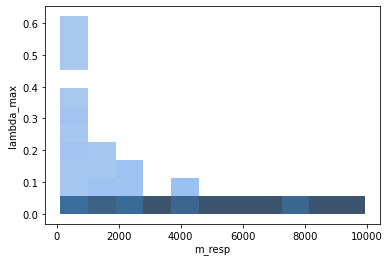

In [8]:
sns.histplot(data=res_df, y='lambda_max', x='m_resp', legend=False)

In [9]:
mask = np.logical_and(res_df.lambda_max > 0.01, res_df.m_ATP_homeostasis > 500)
cols = 'ZCB,S6,phi_O,m_resp,resp_ATP_per_e,m_ATP_homeostasis,lambda_max,anabolism_phi'.split(',')
res_df[mask][cols].sort_values('lambda_max', ascending=False)

,ZCB,S6,phi_O,m_resp,resp_ATP_per_e,m_ATP_homeostasis,lambda_max,anabolism_phi
535,-0.364617,0.182308,0.377547,130.577962,1.486060,2477.105979,0.453067,0.251704
610,-0.620308,0.310154,0.332422,483.827870,0.855457,1054.249928,0.384048,0.213360
611,-0.620308,0.310154,0.332422,483.827870,0.855457,1634.651735,0.333789,0.185438
609,-0.620308,0.310154,0.332422,483.827870,0.804699,1634.651735,0.322533,0.179185
607,-0.274042,0.137021,0.332422,483.827870,0.855457,1634.651735,0.314961,0.174978
...,...,...,...,...,...,...,...,...
253,0.808519,-0.404260,0.469768,4456.850392,1.432999,1143.644823,0.012189,0.006772
252,0.808519,-0.404260,0.471408,4456.850392,1.432999,1143.644823,0.011950,0.006639
477,-0.173657,0.086829,0.390423,6891.265399,1.826326,1325.639921,0.011298,0.006277
223,-0.775246,0.387623,0.429055,6278.283152,1.800713,1422.716795,0.011288,0.006271


/opt/miniconda3/lib/python3.8/site-packages/cvxpy/reductions/solvers/solving_chain.py:178: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Discplined Parametrized Programming, at
	https://www.cvxpy.org/tutorial/advanced/index.html#disciplined-parametrized-programming
  warnings.warn(dpp_error_msg)


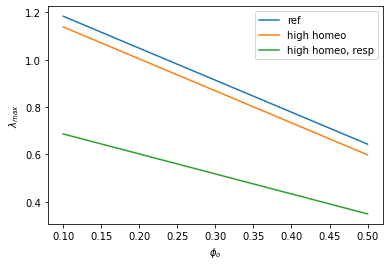

In [10]:
ref_lam = LinearRespirationModel.FromFiles(m_fname, S_fname)

high_homeo_lam = LinearRespirationModel.FromFiles(m_fname, S_fname)
high_homeo_lam.set_process_mass('ATP_homeostasis', 400) # 4x baseline

high_homeo_resp_lam = LinearRespirationModel.FromFiles(m_fname, S_fname)
high_homeo_resp_lam.set_process_mass('ATP_homeostasis', 400) # 4x baseline
high_homeo_resp_lam.set_process_mass('reduction', 400) # 4x baseline

phi_os = np.arange(0.1, 0.501, 0.1)
ref_lambdas = [ref_lam.maximize_lambda(phi_o=p)[0] for p in phi_os]
high_homeo_lambdas = [high_homeo_lam.maximize_lambda(phi_o=p)[0] for p in phi_os]
high_homeo_resp_lambdas = [high_homeo_resp_lam.maximize_lambda(phi_o=p)[0] for p in phi_os]

plt.plot(phi_os, ref_lambdas, label='ref')
plt.plot(phi_os, high_homeo_lambdas, label='high homeo')
plt.plot(phi_os, high_homeo_resp_lambdas, label='high homeo, resp')
plt.legend()
plt.xlabel(r'$\phi_o$')
plt.ylabel(r'$\lambda_{max}$')
plt.show()

In [11]:
ZCBs = np.arange(-1, 1.01, 0.05)
phi_os = np.arange(0.1, 0.501, 0.2)
homeo_costs = np.logspace(1, 3, 3)
resp_costs = np.logspace(1, 3, 3)
ATP_per_es = [0.25, 0.5, 1, 2]

ref_lam = LinearRespirationModel.FromFiles(m_fname, S_fname)
res_dict = dict(ZCB=[], phi_o=[], homeo_cost=[], lambda_max=[], S6=[], resp_cost=[], resp_ATP_per_e=[])

for z in ZCBs:
    ref_lam.set_ZCB(z)
    for phi_o in phi_os:
        for homeo_cost in homeo_costs:
            for resp_cost in resp_costs:
                for atp_per_e in ATP_per_es:
                    ref_lam.set_process_mass('reduction', resp_cost)
                    ref_lam.set_process_mass('ATP_homeostasis', homeo_cost)
                    ref_lam.set_ATP_yield('reduction', atp_per_e)
                    m, _ = ref_lam.maximize_lambda(phi_o=phi_o)
                    res_dict['ZCB'].append(z)
                    res_dict['phi_o'].append(phi_o)
                    res_dict['homeo_cost'].append(homeo_cost)
                    res_dict['lambda_max'].append(m)
                    res_dict['S6'].append(ref_lam.get_S6())
                    res_dict['resp_cost'].append(resp_cost)
                    res_dict['resp_ATP_per_e'].append(atp_per_e)
res_df = pd.DataFrame(res_dict)

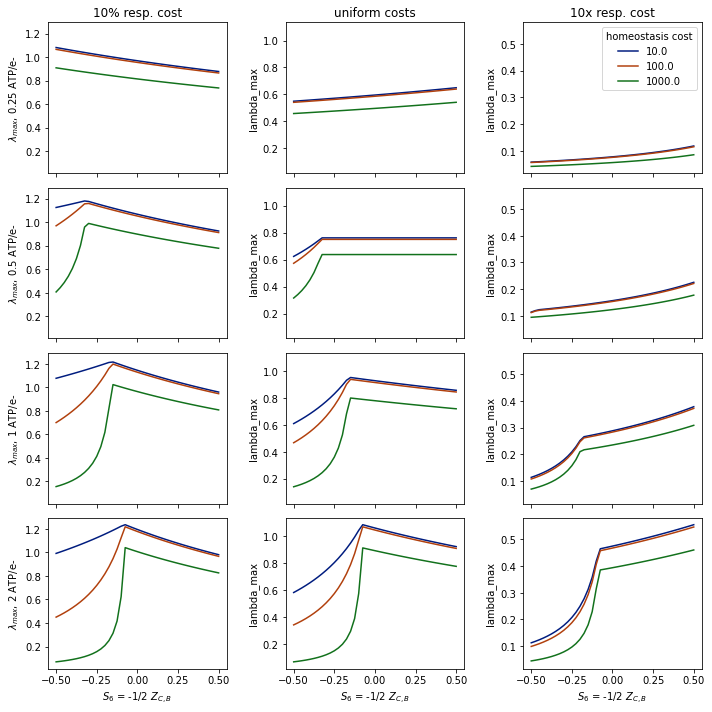

In [12]:
fig, axs = plt.subplots(figsize=(10, 10), nrows=4, ncols=3, sharex=True, sharey='col')

titles = '10% resp. cost,uniform costs,10x resp. cost'.split(',')
for i, a_per_e in enumerate(ATP_per_es):
    for j, resp_cost in enumerate(resp_costs):
        plt.sca(axs[i, j])
        mask = np.logical_and(res_df.resp_cost == resp_cost, res_df.phi_o == phi_os[1])
        mask = np.logical_and(mask, res_df.resp_ATP_per_e == a_per_e)
        sns.lineplot(data=res_df[mask], x='S6', y='lambda_max', hue='homeo_cost', palette='dark')
        plt.xlabel('$S_6$ = -1/2 $Z_{C,B}$')
        plt.legend().set_visible(False)

        if i == 0:
            plt.title(titles[j])
        
        if j == 0:
            plt.ylabel(r'$\lambda_{{max}}$, {0} ATP/e-'.format(a_per_e))

plt.sca(axs[0,2])
plt.legend(title='homeostasis cost').set_visible(True)

plt.tight_layout()
plt.savefig('../output/lambda_max_vs_S6.png', dpi=300, facecolor='white')
plt.show()